##Modelo Predictivo de Prepagos Hipotecarios
# Modelo Final

El objetivo de esta sección es utilizar modelos ensamblados para mejorar el desempeño.

##Carga de información

Se cargan las librerías necesarias y el archivo con los datos ya preprocesados.

In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA
from functools import partial

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import itertools
import shap


from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

In [423]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [424]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Modelos Alternativos/datos_preprocesados2.xlsx"
df = pd.read_excel(file_path, sheet_name = "Datos")

In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   pla_credit                             7381 non-null   int64  
 1   edad_cliente                           7381 non-null   float64
 2   score                                  7381 non-null   float64
 3   tasa                                   7381 non-null   float64
 4   plazo_original_meses                   7381 non-null   float64
 5   edad_credito                           7381 non-null   float64
 6   cantidad_prepago_ratio                 7381 non-null   float64
 7   prepago_total_ratio                    7381 non-null   float64
 8   enganche_ratio                         7381 non-null   float64
 9   cantidad_prepago_1                     7381 non-null   float64
 10  cantidad_prepago_2                     7381 non-null   float64
 11  cant

A continuación filtraremos los créditos con los que no se cuenta información antes de septiembre 2025. Al ajustar distintos modelos, se identificó que los modelos se equivocaban principalmente en los créditos sin suficiente información, por lo que se aplicará este filtro y se incorporará en los supuestos del modelo, para precisar que únicamente se enfoca en los créditos que cuenten con historia desde, al menos, 3 meses antes del mes de predicción.

In [426]:
df = df[df['filtro oct'].isnull()]
df = df[df['filtro sep'].isnull()]
df = df.drop(columns=['filtro oct', 'filtro sep', 'filtro ago'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6303 entries, 0 to 7380
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   pla_credit                             6303 non-null   int64  
 1   edad_cliente                           6303 non-null   float64
 2   score                                  6303 non-null   float64
 3   tasa                                   6303 non-null   float64
 4   plazo_original_meses                   6303 non-null   float64
 5   edad_credito                           6303 non-null   float64
 6   cantidad_prepago_ratio                 6303 non-null   float64
 7   prepago_total_ratio                    6303 non-null   float64
 8   enganche_ratio                         6303 non-null   float64
 9   cantidad_prepago_1                     6303 non-null   float64
 10  cantidad_prepago_2                     6303 non-null   float64
 11  cantidad_

# Parte 1: Modelo de Clasificación

**- Variable objetivo:** 'prepago_dic' (1 = el cliente prepaga en diciembre 2024; 0 = no prepaga).

**- Tipo de modelo:** Clasificación supervisada.

**Tratamiento de datos y balance de clases**

Los datos fueron previamente estructurados, transformados y escalados. Sin embargo, se identificó un desequilibrio en las clases (mayor proporción de clientes sin prepago). Para mitigar este sesgo y evitar un modelo sobreajustado, se aplicó una submuestra aleatoria (undersampling) de la clase mayoritaria, igualando el número de observaciones entre prepagos y no prepagos.

In [427]:
#primero hacemos el undersampling

df_0 = df[df["prepago_dic"] == 0]
df_1 = df[df["prepago_dic"] == 1]

df_0_sample = resample(df_0, replace=False, n_samples=len(df_1), random_state=0)

df_sample = pd.concat([df_1, df_0_sample])

In [428]:
#definimos las bases para X y y

#consideramos exclusiones del Avance 2
var_excluidas = ["pla_credit", "clasificacion","estado", "prepago_dic", "tasa", "estado_civil", "clasificacion_otros", "enganche_ratio", "edad_cliente", "region_Bajio-Occidente", "plazo_original_meses", "region_Noroeste", "region_Centro-Sur"]

var_x = [col for col in df_sample.columns if col not in var_excluidas]
var_y = "prepago_dic"

X = df_sample[var_x]
y = df_sample[var_y]

In [429]:
#definimos las bases de train y test para X y y, considerando que el prepago_dic esté balanceado en ambas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

#Modelos Seleccionados en fase anterior

A continuación se muestran los mejores modelos individuales de la fase anterior: XGBoost y SVM. Los hiperparámetros de estos modelos ya fueron optimizados en la fase anterior.

#Calibración XGBoost

In [430]:
model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=5, subsample=0.6, random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

def metricas(y_pred_train, y_pred_test, y_train, y_test):
    metricas_train = {
            "accuracy": accuracy_score(y_train, y_pred_train),
            "precision": precision_score(y_train, y_pred_train),
            "recall": recall_score(y_train, y_pred_train),
            "f1": f1_score(y_train, y_pred_train)
        }

    metricas_test = {
            "accuracy": accuracy_score(y_test, y_pred_test),
            "precision": precision_score(y_test, y_pred_test),
            "recall": recall_score(y_test, y_pred_test),
            "f1": f1_score(y_test, y_pred_test)
        }

    print("Métricas Train")
    for k,v in metricas_train.items(): print(f"{k}: {v:.4f}")
    print("\nMétricas Test")
    for k,v in metricas_test.items(): print(f"{k}: {v:.4f}")

    # gap para sub/sobreajuste
    print("\nSub/sobreajuste")
    for k in metricas_test.keys():
        gap = metricas_train[k] - metricas_test[k]
        print(f"{k:7s}  gap(train-test): {gap:+.2f}")

    # matriz de confusión
    print("\nMatriz de Confusión")
    print(confusion_matrix(y_test, y_pred_test))

    return metricas_train, metricas_test

metricas_train_XGBoost, metricas_test_XGBoost = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.8307
precision: 0.8807
recall: 0.7649
f1: 0.8188

Métricas Test
accuracy: 0.7870
precision: 0.8163
recall: 0.7407
f1: 0.7767

Sub/sobreajuste
accuracy  gap(train-test): +0.04
precision  gap(train-test): +0.06
recall   gap(train-test): +0.02
f1       gap(train-test): +0.04

Matriz de Confusión
[[90 18]
 [28 80]]


#Calibración SVM

In [431]:
model = SVC(kernel='rbf', C=0.5, gamma=0.5)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metricas_train_SVM, metricas_test_SVM = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7470
precision: 0.7230
recall: 0.8008
f1: 0.7599

Métricas Test
accuracy: 0.7500
precision: 0.7288
recall: 0.7963
f1: 0.7611

Sub/sobreajuste
accuracy  gap(train-test): -0.00
precision  gap(train-test): -0.01
recall   gap(train-test): +0.00
f1       gap(train-test): -0.00

Matriz de Confusión
[[76 32]
 [22 86]]


##Modelo Individual

Se elige el modelo SVM, ya que muestra un 76% de f1, precisión de 73% y recall de 80%.

Aunque disminuye la precisión en comparación a otros modelos, el recall, que es la métrica principal, es mayor, ya que nos interesa identificar a la mayor cantidad de clases positivas posibles.

# Ensambles Homogéneos

Primero se intentará combinar varios modelos del mismo tipo con SVM.

# 1. Bagging

No lo mejora mucho porque Bagging mejora sobre todo modelos de alta varianza, y SVM es ya muy estable.

In [432]:
bagging_svm = BaggingClassifier(
    estimator = SVC(kernel='rbf', C=0.5, gamma=0.5),
    n_estimators = 50,
    max_samples = 1.0,
    max_features = 0.8,
    bootstrap = True,
    random_state = 0
)

bagging_svm.fit(X_train, y_train)

y_pred_train = bagging_svm.predict(X_train)
y_pred_test = bagging_svm.predict(X_test)

metricas_train_1Bagging, metricas_test_1Bagging = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7550
precision: 0.7462
recall: 0.7729
f1: 0.7593

Métricas Test
accuracy: 0.7361
precision: 0.7339
recall: 0.7407
f1: 0.7373

Sub/sobreajuste
accuracy  gap(train-test): +0.02
precision  gap(train-test): +0.01
recall   gap(train-test): +0.03
f1       gap(train-test): +0.02

Matriz de Confusión
[[79 29]
 [28 80]]


# 2. Boosting

Probaremos con AdaBoost.

In [433]:
base_tree = DecisionTreeClassifier(max_depth = 2, random_state = 0)

adaboost = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=100,
    learning_rate=0.5,
    random_state = 0
)

adaboost.fit(X_train, y_train)

y_pred_train = adaboost.predict(X_train)
y_pred_test = adaboost.predict(X_test)

metricas_train_2Boosting, metricas_test_2Boosting = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7570
precision: 0.7919
recall: 0.6972
f1: 0.7415

Métricas Test
accuracy: 0.7731
precision: 0.8105
recall: 0.7130
f1: 0.7586

Sub/sobreajuste
accuracy  gap(train-test): -0.02
precision  gap(train-test): -0.02
recall   gap(train-test): -0.02
f1       gap(train-test): -0.02

Matriz de Confusión
[[90 18]
 [31 77]]


#Ensambles Heterogéneos

#3. Stacking

In [434]:
svm_base = SVC(kernel='rbf', C=0.5, gamma=0.8, probability = True, random_state=0)

xgb_base = XGBClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=0
)

meta = LogisticRegression(max_iter=2000, random_state=0)

stack = StackingClassifier(
    estimators=[('svm', svm_base), ('xgb', xgb_base)],
    final_estimator=meta,
    stack_method='predict_proba',
    cv=5,
    passthrough=False
)


svm_base.fit(X_train, y_train)
xgb_base.fit(X_train, y_train)

#y_prob_svm = svm_base.predict_proba(X_test)[:, 1]
#y_prob_xgb = xgb_base.predict_proba(X_test)[:, 1]

# Stacking
stack.fit(X_train, y_train)

y_pred_train = stack.predict(X_train)
y_pred_test = stack.predict(X_test)

y_prob_train = stack.predict_proba(X_train)[:, 1]
y_prob_test = stack.predict_proba(X_test)[:, 1]

#y_pred_train = (y_prob_train >= 0.5).astype(int)
#y_pred_test = (y_prob_test >= 0.5).astype(int)

metricas_train_3st, metricas_test_3st = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7928
precision: 0.8000
recall: 0.7809
f1: 0.7903

Métricas Test
accuracy: 0.7546
precision: 0.7619
recall: 0.7407
f1: 0.7512

Sub/sobreajuste
accuracy  gap(train-test): +0.04
precision  gap(train-test): +0.04
recall   gap(train-test): +0.04
f1       gap(train-test): +0.04

Matriz de Confusión
[[83 25]
 [28 80]]


Como el modelo tiene buenos resultados y combina los dos modelos individuales con mejor desempeño, se probará ajustar el umbral de las probabilidades para mejorar las métricas.

In [435]:
prec, rec, thr = precision_recall_curve(y_test, y_prob_test)

f1s = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1s)
thr_f1 = thr[best_idx]
print(f"Umbral que maximiza F1: {thr_f1:.3f}")

Umbral que maximiza F1: 0.406


In [436]:
svm_base = SVC(kernel='rbf', C=0.5, gamma=0.8, probability = True, random_state=0)

xgb_base = XGBClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=0
)

meta = LogisticRegression(max_iter=2000, random_state=0)

stack = StackingClassifier(
    estimators=[('svm', svm_base), ('xgb', xgb_base)],
    final_estimator=meta,
    stack_method='predict_proba',
    cv=5,
    passthrough=False
)


svm_base.fit(X_train, y_train)
xgb_base.fit(X_train, y_train)

#y_prob_svm = svm_base.predict_proba(X_test)[:, 1]
#y_prob_xgb = xgb_base.predict_proba(X_test)[:, 1]

# Stacking
stack.fit(X_train, y_train)

#y_pred_train = stack.predict(X_train)
#y_pred_test = stack.predict(X_test)

y_prob_train = stack.predict_proba(X_train)[:, 1]
y_prob_test = stack.predict_proba(X_test)[:, 1]

y_pred_train = (y_prob_train >= 0.4).astype(int)
y_pred_test = (y_prob_test >= 0.4).astype(int)

metricas_train_3st, metricas_test_3st = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7709
precision: 0.7519
recall: 0.8088
f1: 0.7793

Métricas Test
accuracy: 0.7685
precision: 0.7458
recall: 0.8148
f1: 0.7788

Sub/sobreajuste
accuracy  gap(train-test): +0.00
precision  gap(train-test): +0.01
recall   gap(train-test): -0.01
f1       gap(train-test): +0.00

Matriz de Confusión
[[78 30]
 [20 88]]


Ahora se probará con un promedio en vez de regresión logística al ponderar el resultado de cada uno de los modelos individuales con "Voting".

In [437]:
svm_base = SVC(kernel='rbf', C=0.5, gamma=0.5, probability = True, random_state=0)

xgb_base = XGBClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=0
)

voting = VotingClassifier(
    estimators=[('svm', svm_base), ('xgb', xgb_base)],
    voting='soft',
    weights=[1, 2]
)

voting.fit(X_train, y_train)

#y_pred_train = voting.predict(X_train)
#y_pred_test = voting.predict(X_test)

y_prob_train = voting.predict_proba(X_train)[:, 1]
y_prob_test = voting.predict_proba(X_test)[:, 1]

y_pred_train = (y_prob_train >= 0.4).astype(int)
y_pred_test = (y_prob_test >= 0.4).astype(int)

metricas_train_3vot, metricas_test_3vot = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7789
precision: 0.7612
recall: 0.8127
f1: 0.7861

Métricas Test
accuracy: 0.7593
precision: 0.7373
recall: 0.8056
f1: 0.7699

Sub/sobreajuste
accuracy  gap(train-test): +0.02
precision  gap(train-test): +0.02
recall   gap(train-test): +0.01
f1       gap(train-test): +0.02

Matriz de Confusión
[[77 31]
 [21 87]]


#4. Blending

In [438]:
# 70% train, 15% valid, 15% test
X_train2, X_aux, y_train2, y_aux = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=0
)
X_test2, X_valid, y_test2, y_valid = train_test_split(
    X_aux, y_aux, test_size=0.50, stratify=y_aux, random_state=0
)

In [439]:
X_train2.shape

(502, 20)

In [440]:
X_test2.shape

(108, 20)

In [441]:
X_valid.shape

(108, 20)

In [442]:
svm_base = SVC(kernel='rbf',
                C=0.5,
                gamma=0.5,
                probability=True,
                random_state=0)

xgb_base = XGBClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_lambda=1.0,
    eval_metric='auc',
    random_state=0
)


svm_base.fit(X_train2, y_train2)
xgb_base.fit(X_train2, y_train2)

p_valid_svm = svm_base.predict_proba(X_valid)[:, 1]
p_valid_xgb = xgb_base.predict_proba(X_valid)[:, 1]

# Matriz de features para el meta-modelo (blender)
Z_valid = np.column_stack([p_valid_svm, p_valid_xgb])

# meta-modelo entrenado en valid
meta = LogisticRegression(max_iter=2000, random_state=0)
meta.fit(Z_valid, y_valid)

# reentrena bases en train y valid y evalúa en test
X_tr_full = np.vstack([X_train2, X_valid])
y_tr_full = np.concatenate([y_train2, y_valid])

svm_base.fit(X_tr_full, y_tr_full)
xgb_base.fit(X_tr_full, y_tr_full)

p_test_svm = svm_base.predict_proba(X_test2)[:, 1]
p_test_xgb = xgb_base.predict_proba(X_test2)[:, 1]

p_train_svm = svm_base.predict_proba(X_tr_full)[:, 1]
p_train_xgb = xgb_base.predict_proba(X_tr_full)[:, 1]
Z_train = np.column_stack([p_train_svm, p_train_xgb])

Z_test = np.column_stack([p_test_svm, p_test_xgb])

# predicción final del blender
p_test_blend = meta.predict_proba(Z_test)[:, 1]
y_pred_test = (p_test_blend >= 0.5).astype(int)
p_train_blend = meta.predict_proba(Z_train)[:, 1]
y_pred_train = (p_train_blend >= 0.5).astype(int)

metricas_train_4bl, metricas_test_4bl = metricas(y_pred_train, y_pred_test, y_tr_full, y_test2)

Métricas Train
accuracy: 0.8049
precision: 0.8207
recall: 0.7803
f1: 0.8000

Métricas Test
accuracy: 0.7130
precision: 0.7170
recall: 0.7037
f1: 0.7103

Sub/sobreajuste
accuracy  gap(train-test): +0.09
precision  gap(train-test): +0.10
recall   gap(train-test): +0.08
f1       gap(train-test): +0.09

Matriz de Confusión
[[39 15]
 [16 38]]


# Selección

In [443]:
rows = []

rows.append(metricas_train_XGBoost)
rows.append(metricas_test_XGBoost)
rows.append(metricas_train_SVM)
rows.append(metricas_test_SVM)
rows.append(metricas_train_1Bagging)
rows.append(metricas_test_1Bagging)
rows.append(metricas_train_2Boosting)
rows.append(metricas_test_2Boosting)
rows.append(metricas_train_3st)
rows.append(metricas_test_3st)
rows.append(metricas_train_3vot)
rows.append(metricas_test_3vot)
rows.append(metricas_train_4bl)
rows.append(metricas_test_4bl)

modelos = [
    "XGBoost_train", "XGBoost_test",
    "SVM_train", "SVM_test",
    "Bagging_train", "Bagging_test",
    "Boosting_train", "Boosting_test",
    "Stacking_train", "Stacking_test",
    "Voting_train", "Voting_test",
    "Blending_train", "Blending_test",
]

met = pd.DataFrame(rows)
met["ModeloFull"] = modelos
met[["Modelo","Conjunto"]] = met["ModeloFull"].str.split("_", expand=True)
met = met.drop(columns=["ModeloFull"])

metrics = ["accuracy", "precision", "recall", "f1"]
long = met.melt(id_vars=["Modelo","Conjunto"], value_vars=metrics,
               var_name="Metrica", value_name="Valor")
tabla = long.pivot_table(index="Modelo", columns=["Conjunto","Metrica"], values="Valor")

for m in metrics:
    tabla[("gap", m)] = tabla[("train", m)] - tabla[("test", m)]

col_order = (
    [("train", m) for m in metrics] +
    [("test", m)  for m in metrics] +
    [("gap", m)   for m in metrics]
)
tabla = tabla[col_order]

tabla.columns = [f"{lvl1}_{lvl2}" for lvl1, lvl2 in tabla.columns]

tabla = tabla.sort_values(by="test_recall", ascending=False)

tabla

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1,gap_accuracy,gap_precision,gap_recall,gap_f1
Modelo,,,,,,,,,,,,
Stacking,0.770916,0.751852,0.808765,0.779271,0.768519,0.745763,0.814815,0.778761,0.002398,0.006089,-0.006050,0.000510
Voting,0.778884,0.761194,0.812749,0.786127,0.759259,0.737288,0.805556,0.769912,0.019625,0.023906,0.007193,0.016216
SVM,0.747012,0.723022,0.800797,0.759924,0.750000,0.728814,0.796296,0.761062,-0.002988,-0.005792,0.004501,-0.001138
Bagging,0.754980,0.746154,0.772908,0.759295,0.736111,0.733945,0.740741,0.737327,0.018869,0.012209,0.032168,0.021968
XGBoost,0.830677,0.880734,0.764940,0.818763,0.787037,0.816327,0.740741,0.776699,0.043640,0.064407,0.024199,0.042064
Boosting,0.756972,0.791855,0.697211,0.741525,0.773148,0.810526,0.712963,0.758621,-0.016176,-0.018671,-0.015752,-0.017095
Blending,0.804918,0.820690,0.780328,0.800000,0.712963,0.716981,0.703704,0.710280,0.091955,0.103709,0.076624,0.089720


El mejor modelo es el Stacking de XGBoost y SVM. Para los gráficos se analizarán este modelo.

#Gráficos

In [444]:
svm_base = SVC(kernel='rbf', C=0.5, gamma=0.8, probability = True, random_state=0)

xgb_base = XGBClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=0
)

meta = LogisticRegression(max_iter=2000, random_state=0)

stack = StackingClassifier(
    estimators=[('svm', svm_base), ('xgb', xgb_base)],
    final_estimator=meta,
    stack_method='predict_proba',
    cv=5,
    passthrough=False
)


svm_base.fit(X_train, y_train)
xgb_base.fit(X_train, y_train)

#y_prob_svm = svm_base.predict_proba(X_test)[:, 1]
#y_prob_xgb = xgb_base.predict_proba(X_test)[:, 1]

# Stacking
stack.fit(X_train, y_train)

#y_pred_train = stack.predict(X_train)
#y_pred_test = stack.predict(X_test)

y_prob_train = stack.predict_proba(X_train)[:, 1]
y_prob_test = stack.predict_proba(X_test)[:, 1]

y_pred_train = (y_prob_train >= 0.4).astype(int)
y_pred_test = (y_prob_test >= 0.4).astype(int)

metricas_train_3st, metricas_test_3st = metricas(y_pred_train, y_pred_test, y_train, y_test)

Métricas Train
accuracy: 0.7709
precision: 0.7519
recall: 0.8088
f1: 0.7793

Métricas Test
accuracy: 0.7685
precision: 0.7458
recall: 0.8148
f1: 0.7788

Sub/sobreajuste
accuracy  gap(train-test): +0.00
precision  gap(train-test): +0.01
recall   gap(train-test): -0.01
f1       gap(train-test): +0.00

Matriz de Confusión
[[78 30]
 [20 88]]


La curva ROC muestra estabilidad, pues la curva de Train se mantiene cerca de la curva Test. Se comprueba la capacidad predictiva del modelo, al ubicarse del lado superior izquierdo (baja tasa de falsos positivos y alta tasa de verdaderos positivos). Por otro lado, el gap de AUC entre train y test es bajo, indicando que el modelo generaliza bien los datos.

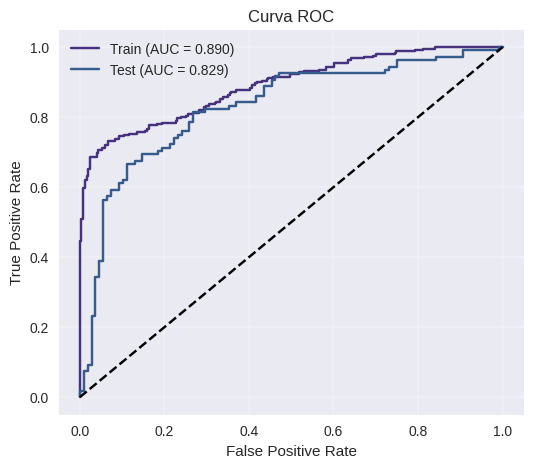

In [445]:
#para curva roc

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


La siguiente gráfica muestra los errores del modelo en color rojo. Como no muestran un patrón, significa que no existe un sesgo importante. En general, hay pocos errores cuando la probabilidad predicha es muy alta (buen nivel de confianza).

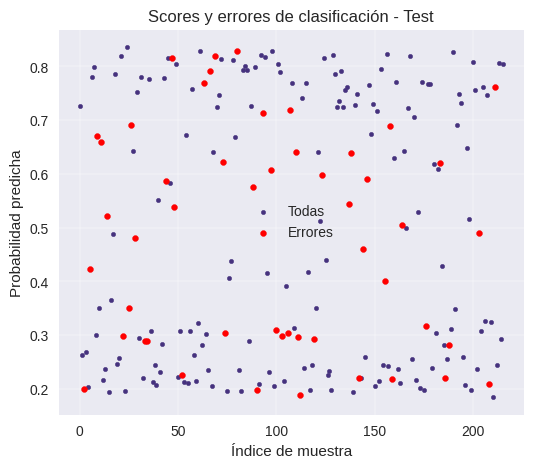

In [446]:
errors = y_pred_test != y_test
plt.figure(figsize=(6, 5))
plt.scatter(np.arange(len(y_prob_test)), y_prob_test, s=10, label='Todas')
plt.scatter(np.where(errors)[0], y_prob_test[errors], s=18, label='Errores', color='r')
plt.xlabel('Índice de muestra')
plt.ylabel('Probabilidad predicha')
plt.title('Scores y errores de clasificación - Test')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

Las cuatro variables de mayor importancia para el modelo con la cantidad de prepagos (en cantidad y monto) hasta noviembre, también la edad del crédito y el score de buró del cliente.

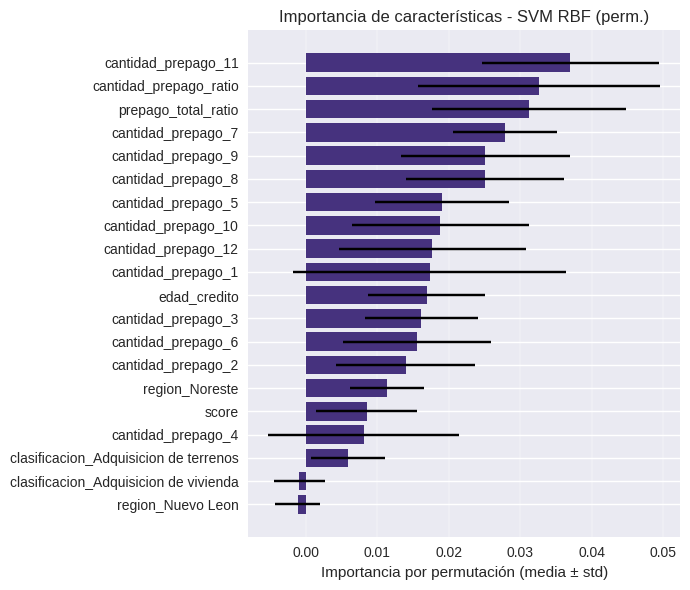

In [447]:
#importancia de características

feature_names = X_train.columns

perm = permutation_importance(
    model, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring='f1'
)
imp_mean = perm.importances_mean
imp_std = perm.importances_std

sorted_idx = np.argsort(imp_mean)
plt.figure(figsize=(7, max(4, len(feature_names) * 0.25 + 1)))
plt.barh(range(len(sorted_idx)), imp_mean[sorted_idx], xerr=imp_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Importancia por permutación (media ± std)')
plt.title('Importancia de características - SVM RBF (perm.)')
plt.grid(True, axis='x', linewidth=0.3)
plt.tight_layout()
plt.show()

# Parte 2: Modelo de Regresión

- Variable objetivo: Tasa de prepago, definida como el monto total prepagado sobre el saldo insoluto de los clientes que prepagan en diciembre.
- Tipo de modelo: Regresión

In [448]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

In [449]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Modelos Alternativos/datos.xlsx"
df_prepago = pd.read_excel(file_path, sheet_name="Prepago")
df_saldo = pd.read_excel(file_path, sheet_name="Saldo Insoluto")

In [450]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Modelos Alternativos/regresores.xlsx"
df_tiie = pd.read_excel(file_path, sheet_name="regresores")

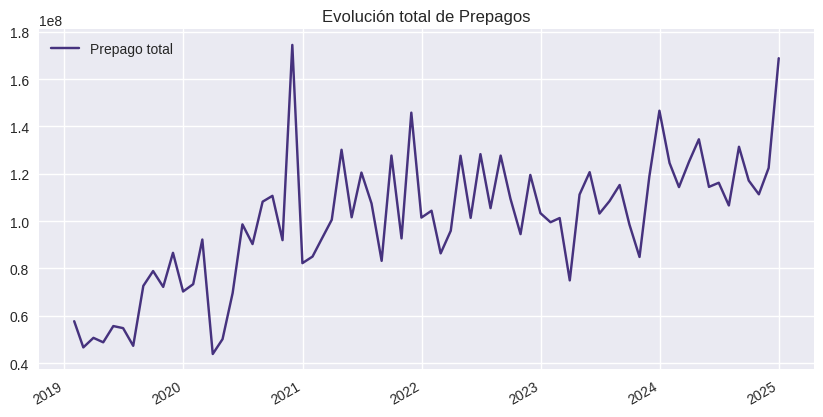

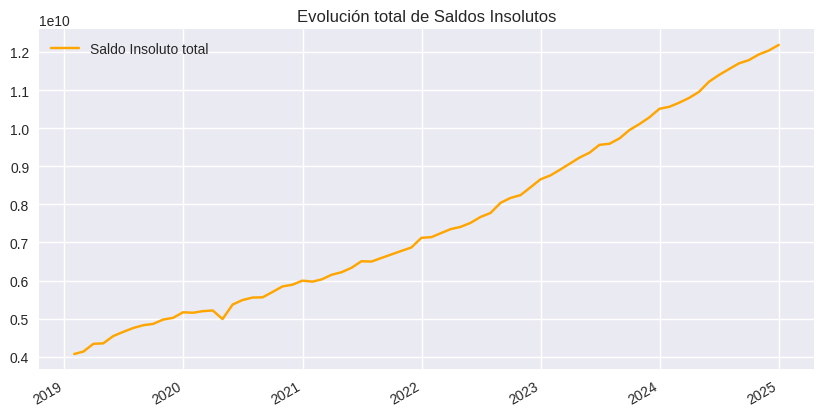

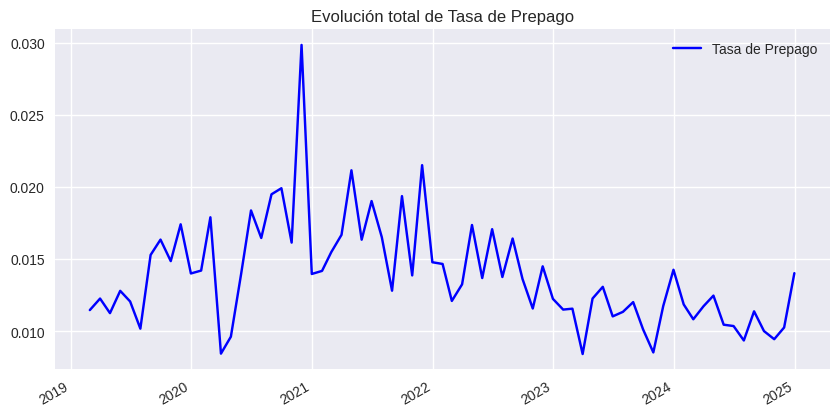

In [451]:
cols = df_saldo.columns
fecha_cols = cols[14:]

prepago_ts = df_prepago[fecha_cols].sum()
saldo_ts = df_saldo[fecha_cols].sum()
tasa_prepago_ts = prepago_ts / saldo_ts.shift(1)

plt.figure(figsize=(10,5))
prepago_ts.plot(label="Prepago total")
plt.title("Evolución total de Prepagos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
saldo_ts.plot(label="Saldo Insoluto total", color="orange")
plt.title("Evolución total de Saldos Insolutos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
tasa_prepago_ts.plot(label="Tasa de Prepago", color="blue")
plt.title("Evolución total de Tasa de Prepago")
plt.legend()
plt.show()

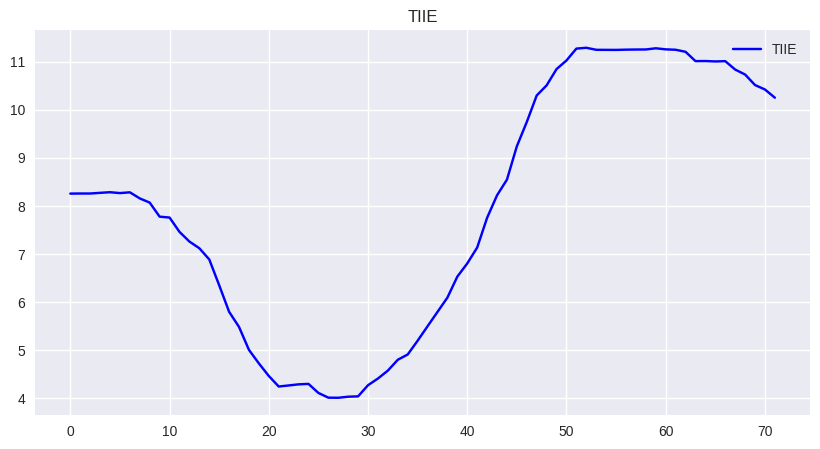

In [452]:
plt.figure(figsize=(10,5))
df_tiie['tiie'].plot(label="TIIE", color="blue")
plt.title("TIIE")
plt.legend()
plt.show()

In [453]:
index = pd.date_range("2019-01-31", periods=72, freq="M")
serie = pd.Series(tasa_prepago_ts.values*100, index=index)
serie = serie.dropna()
serie

,0
2019-02-28,1.146488
2019-03-31,1.226422
2019-04-30,1.125386
2019-05-31,1.279943
2019-06-30,1.206334
...,...
2024-08-31,1.137825
2024-09-30,1.000886
2024-10-31,0.944625
2024-11-30,1.025859


In [454]:
tiie = pd.Series(df_tiie['tiie'].values, index=index)
tiie = tiie.iloc[1:72]
tiie

,0
2019-02-28,8.259474
2019-03-31,8.259500
2019-04-30,8.273500
2019-05-31,8.286364
2019-06-30,8.268500
...,...
2024-08-31,10.835909
2024-09-30,10.732500
2024-10-31,10.514091
2024-11-30,10.421500


In [455]:
serie

,0
2019-02-28,1.146488
2019-03-31,1.226422
2019-04-30,1.125386
2019-05-31,1.279943
2019-06-30,1.206334
...,...
2024-08-31,1.137825
2024-09-30,1.000886
2024-10-31,0.944625
2024-11-30,1.025859


## Modelos Individuales

Los modelos individuales seleccionados fueron XGBoost, Random Forest Regressor y SARIMAX.

##XGBoost

In [456]:
def caracteristicas_temporales(serie, tiie, lags=[1,2,3], ventanas=[3,6]):

    df = pd.DataFrame({
        'y': serie,
        'TIIE': tiie
    })

    # se agregan lags de datos pasados de la tiie
    for lag in lags:
        df[f'lag_tiie_{lag}'] = tiie.shift(lag)

    # se agregan lags de datos pasados de la misma serie
    for lag in lags:
        df[f'lag_{lag}'] = serie.shift(lag)

    # se agregan medias móviles de la serie, con distintas ventanas
    for w in ventanas:
        df[f'ma_{w}'] = serie.rolling(window=w).mean().shift(1)

    # variaciones porcentuales
    df['ret_1'] = serie.pct_change(1).shift(1)
    df['ret_3'] = serie.pct_change(3).shift(1)

    #quitar NA
    df = df.dropna()

    return df

In [457]:
backtest_months = 12
start_idx = len(serie) - backtest_months

preds = []
reales = []
idx_bt = serie.index[start_idx:]

for t in range(start_idx, len(serie)):

    df = caracteristicas_temporales(serie.iloc[:t], tiie.iloc[:t],
                                   lags=[1,2,3,6], ventanas=[3,6])

    X = df.drop(columns=['y'])
    y = df['y']

    model = XGBRegressor(
        n_estimators=500, learning_rate=0.5, max_depth=5, colsample_bytree=0.5, random_state=0
    )
    model.fit(X, y)

    df_new = caracteristicas_temporales(serie.iloc[:t+1], tiie.iloc[:t+1],
                                       lags=[1,2,3,6], ventanas=[3,6]).iloc[-1:]
    x_new = df_new.drop(columns=['y'])

    y_hat = pd.Series(model.predict(x_new), index=x_new.index)

    preds.append(y_hat.iloc[0])
    reales.append(serie.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE_xgboost = float((y_real - y_pred).abs().mean())
MAPE_xgboost = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE_xgboost:.6f}")
print(f"MAPE: {MAPE_xgboost:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.105350
MAPE: 9.4626%


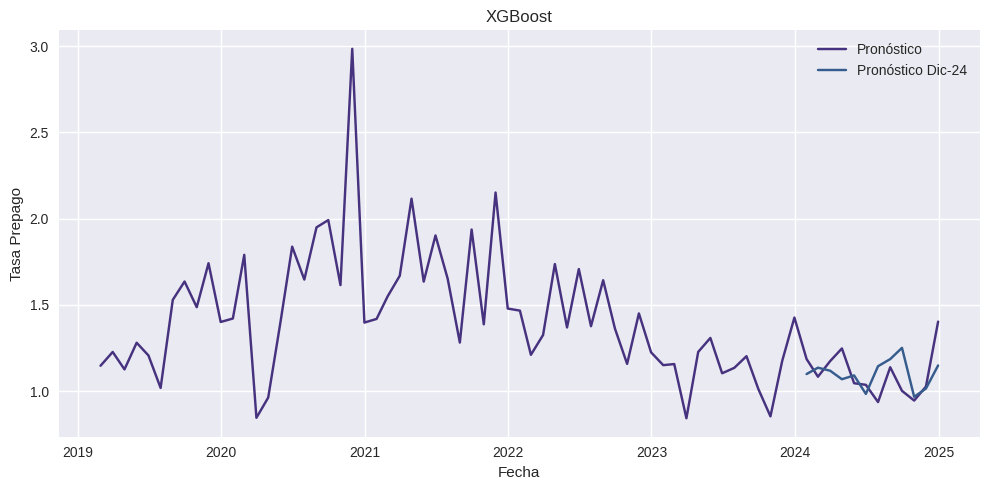

In [458]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Pronóstico")
plt.plot(y_pred.index, y_pred.values, label="Pronóstico Dic-24")
plt.title(f"XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

## Random Forest Regressor



In [459]:
backtest_months = 12
start_idx = len(serie) - backtest_months

preds = []
reales = []
idx_bt = serie.index[start_idx:]

for t in range(start_idx, len(serie)):

    df = caracteristicas_temporales(serie.iloc[:t], tiie.iloc[:t],
                                   lags=[1,2,3,6], ventanas=[3,6,12])

    X = df.drop(columns=['y'])
    y = df['y']

    rf = RandomForestRegressor(
        n_estimators=400, max_depth=10, min_samples_leaf=5,
        max_features='sqrt', random_state=0
    )
    rf.fit(X, y)

    df_new = caracteristicas_temporales(serie.iloc[:t+1], tiie.iloc[:t+1],
                                       lags=[1,2,3,6], ventanas=[3,6,12]).iloc[-1:]
    x_new = df_new.drop(columns=['y'])

    y_hat = pd.Series(rf.predict(x_new), index=x_new.index)

    preds.append(y_hat.iloc[0])
    reales.append(serie.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE_rf = float((y_real - y_pred).abs().mean())
MAPE_rf = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE_rf:.6f}")
print(f"MAPE: {MAPE_rf:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.107448
MAPE: 9.8165%


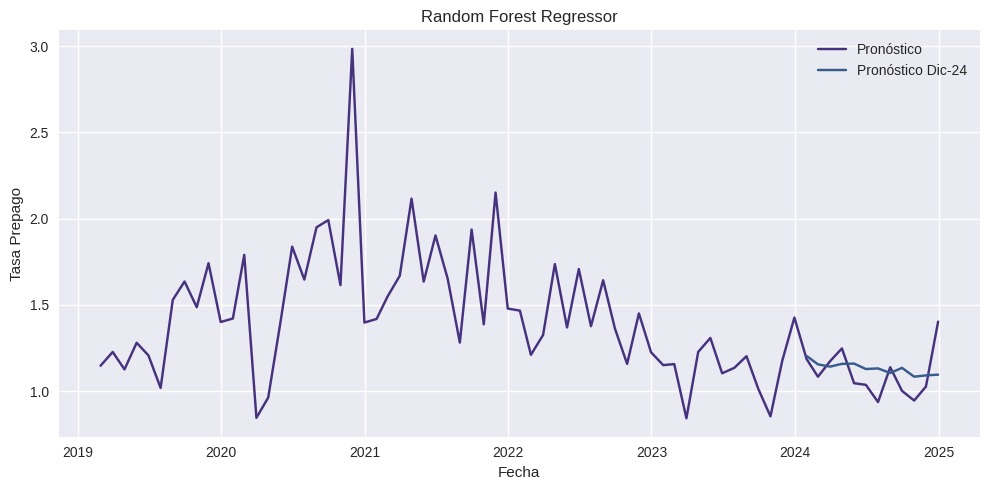

In [460]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Pronóstico")
plt.plot(y_pred.index, y_pred.values, label="Pronóstico Dic-24")
plt.title(f"Random Forest Regressor")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

## SARIMAX



In [461]:
df = pd.DataFrame({
        'y': serie,
        'TIIE': tiie
    })

# se agregan lags de datos pasados de la tiie
for lag in [1,3,6,12]:
    df[f'lag_tiie_{lag}'] = tiie.shift(lag)

#quitar NA
df = df.dropna()

In [462]:
s = 12
RANGE_p = range(0, 2) # AR
RANGE_d = range(0, 2) # diferenciación
RANGE_q = range(0, 2) # medias móviles
RANGE_P = range(0, 2)
RANGE_D = range(0, 2)
RANGE_Q = range(0, 2)

ranges={"p":RANGE_p, "d":RANGE_d, "q":RANGE_q,
            "P":RANGE_P, "D":RANGE_D, "Q":RANGE_Q}

y = df['y']
X = df.drop(columns=['y'])

best = {"aic": np.inf, "order": None, "sorder": None}

for p,d,q in product(ranges["p"], ranges["d"], ranges["q"]):
        for P,D,Q in product(ranges["P"], ranges["D"], ranges["Q"]):
            order = (p,d,q)
            sorder = (P,D,Q, s)
            mod = SARIMAX(endog=y, exog=X,
                          order=order, seasonal_order=sorder,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best["aic"]:
                best = {"aic": res.aic, "order": order, "sorder": sorder}


In [463]:
print(f"Mejor orden encontrado por AIC:\n  order={order}, seasonal_order={sorder}, AIC={best['aic']:.2f}")

Mejor orden encontrado por AIC:
  order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), AIC=-6.12


In [464]:
backtest_months = 12
start_idx = df.shape[0] - backtest_months

preds = []
reales = []
idx_bt = df.index[start_idx:]

for t in range(start_idx, df.shape[0]):

    df_aux = df.iloc[:t]

    X = df_aux.drop(columns=['y'])
    y = df_aux['y']

    rf = SARIMAX(endog=y, exog=X,
                          order=(1,1,1), seasonal_order=(1,1,1,12),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
    res = rf.fit(disp=False)

    df_new = df.iloc[[t]]

    x_new = df_new.drop(columns=['y'])
    x_new = x_new.reindex(columns=X.columns)

    y_hat = pd.Series(res.get_forecast(steps = 1, exog = x_new).predicted_mean)

    preds.append(y_hat.iloc[0])
    reales.append(serie.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE_sarimax = float((y_real - y_pred).abs().mean())
MAPE_sarimax = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE_sarimax:.6f}")
print(f"MAPE: {MAPE_sarimax:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.264985
MAPE: 23.1438%


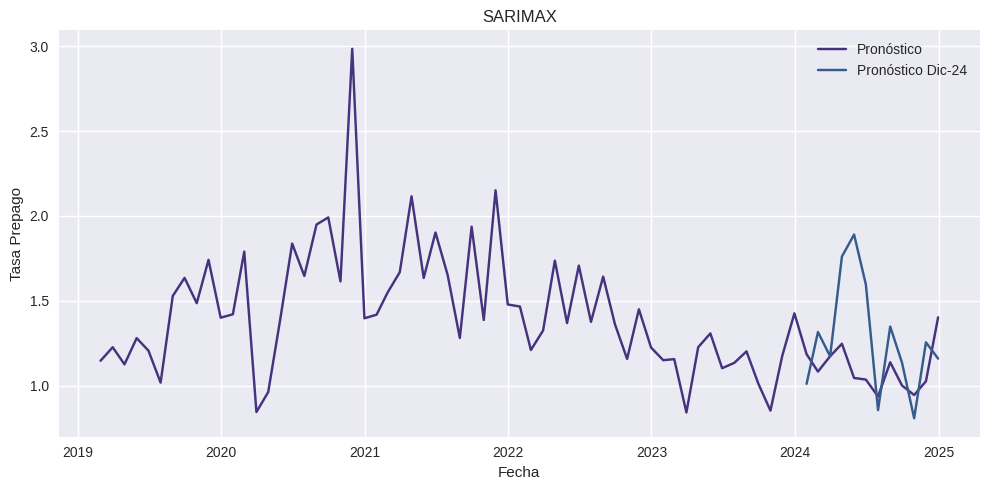

In [465]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Pronóstico")
plt.plot(y_pred.index, y_pred.values, label="Pronóstico Dic-24")
plt.title(f"SARIMAX")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

# Ensambles Homogéneos

Primero se intentará combinar varios modelos del mismo tipo.

# 1. Bagging

In [466]:

df_all = caracteristicas_temporales(serie, tiie, lags=(1,2,3,6,12), ventanas=(3,6,12)).copy()
X_all = df_all.drop(columns=['y'])
y_all = df_all['y']

start_idx = len(df_all) - backtest_months
idx_bt = df_all.index[start_idx:]

preds, reals = [], []

for t in range(start_idx, len(df_all)):
    X_tr = X_all.iloc[:t]
    y_tr = y_all.iloc[:t]
    x_new = X_all.iloc[[t]]

    bag = BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=0),
        n_estimators=100,
        max_samples=0.8,
        bootstrap=True,
        random_state=0
    )
    bag.fit(X_tr, y_tr)
    preds.append(bag.predict(x_new)[0])
    reals.append(y_all.iloc[t])

y_pred = pd.Series(preds, index=idx_bt)
y_real = pd.Series(reals, index=idx_bt)

MAE_bagging  = float((y_real - y_pred).abs().mean())
MAPE_bagging = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)


print(f"MAE : {MAE_bagging:.6f}")
print(f"MAPE: {MAPE_bagging:.4f}%")

MAE : 0.096028
MAPE: 8.4943%


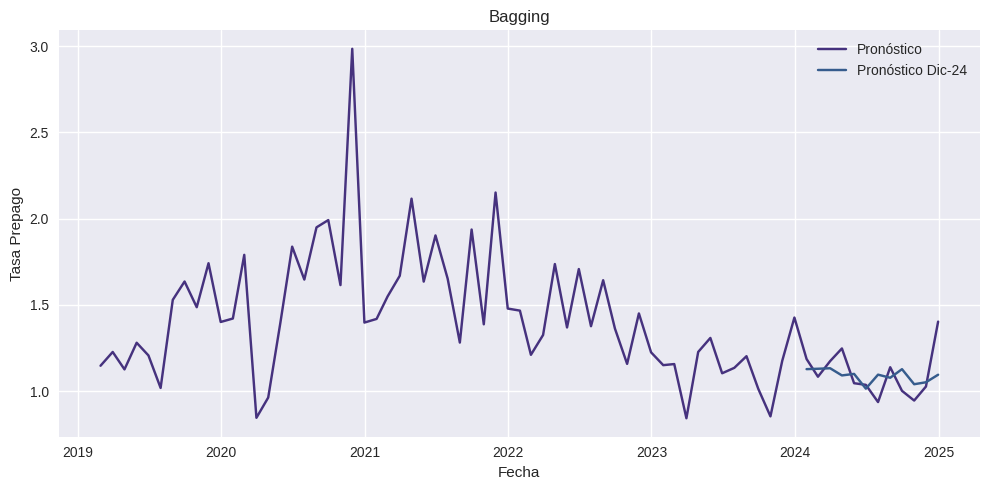

In [467]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Pronóstico")
plt.plot(y_pred.index, y_pred.values, label="Pronóstico Dic-24")
plt.title(f"Bagging")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Boosting

In [468]:
preds, reals = [], []

gbr = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    random_state=0
)

for t in range(start_idx, len(df_all)):
    X_tr = X_all.iloc[:t]
    y_tr = y_all.iloc[:t]
    x_new = X_all.iloc[[t]]

    gbr.fit(X_tr, y_tr)
    preds.append(gbr.predict(x_new)[0])
    reals.append(y_all.iloc[t])

y_pred = pd.Series(preds, index=idx_bt)
y_real = pd.Series(reals, index=idx_bt)

MAE_boosting  = float((y_real - y_pred).abs().mean())
MAPE_boosting = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print(f"MAE : {MAE_boosting:.6f}")
print(f"MAPE: {MAPE_boosting:.4f}%")

MAE : 0.095750
MAPE: 8.5790%


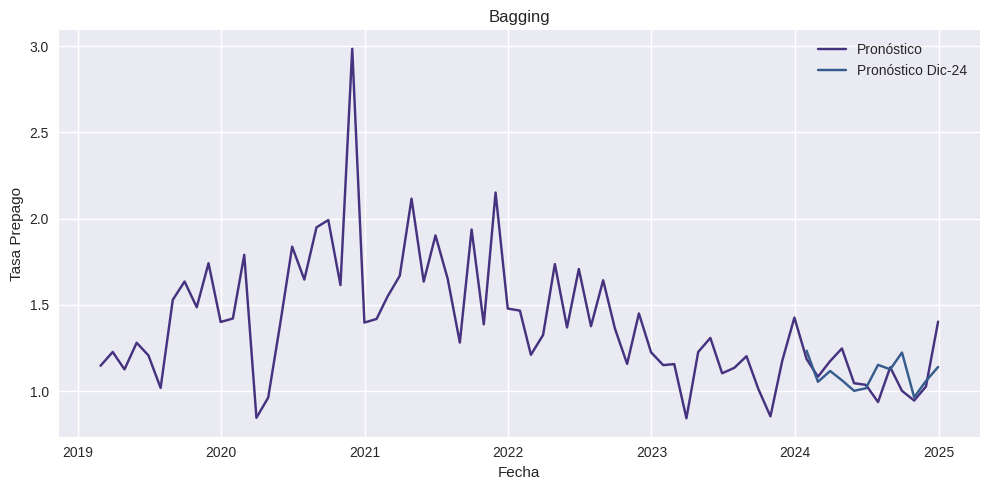

In [469]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Pronóstico")
plt.plot(y_pred.index, y_pred.values, label="Pronóstico Dic-24")
plt.title(f"Bagging")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

#Ensambles Heterogéneos

#3. Stacking

In [470]:
base1 = XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=0, tree_method='hist'
)
base2 = RandomForestRegressor(
    n_estimators=600, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, random_state=0
)

meta = Ridge(alpha=1.0, random_state=0)


#para predicciones Out Of Fold se utilizará TimeSeriesSplit para entrenamiento
tscv = TimeSeriesSplit(n_splits=5)
oof_pred_b1 = pd.Series(index=X_all.index, dtype=float)
oof_pred_b2 = pd.Series(index=X_all.index, dtype=float)

for tr_idx, val_idx in tscv.split(X_all):
    X_tr, X_val = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    y_tr, y_val = y_all.iloc[tr_idx], y_all.iloc[val_idx]

    b1 = base1.__class__(**base1.get_params())
    b2 = base2.__class__(**base2.get_params())
    b1.fit(X_tr, y_tr)
    b2.fit(X_tr, y_tr)

    oof_pred_b1.iloc[val_idx] = b1.predict(X_val)
    oof_pred_b2.iloc[val_idx] = b2.predict(X_val)

valid_mask = oof_pred_b1.notna() & oof_pred_b2.notna()
Z_oof = pd.DataFrame({
    'b1_xgb': oof_pred_b1[valid_mask],
    'b2_rf':  oof_pred_b2[valid_mask],
}, index=X_all.index[valid_mask])

Z_oof = pd.concat([Z_oof, X_all.loc[Z_oof.index]], axis=1)

y_oof = y_all.loc[Z_oof.index]

meta.fit(Z_oof, y_oof)

start_idx = len(df_all) - backtest_months
idx_bt = df_all.index[start_idx:]
preds, reals = [], []

for t in range(start_idx, len(df_all)):

    X_tr = X_all.iloc[:t]
    y_tr = y_all.iloc[:t]

    b1 = base1.__class__(**base1.get_params())
    b2 = base2.__class__(**base2.get_params())
    b1.fit(X_tr, y_tr)
    b2.fit(X_tr, y_tr)

    x_new = X_all.iloc[[t]].reindex(columns=X_tr.columns)
    p1 = b1.predict(x_new)[0]
    p2 = b2.predict(x_new)[0]

    z_new = pd.DataFrame({'b1_xgb': [p1], 'b2_rf': [p2]}, index=x_new.index)
    z_new = pd.concat([z_new, x_new], axis=1)

    y_hat = float(meta.predict(z_new)[0])

    preds.append(y_hat)
    reals.append(y_all.iloc[t])

y_pred = pd.Series(preds, index=idx_bt, name='Pronosticado')
y_real = pd.Series(reals, index=idx_bt, name='Real')

MAE_st  = float((y_real - y_pred).abs().mean())
MAPE_st = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print(f"MAE : {MAE_st:.6f}")
print(f"MAPE: {MAPE_st:.4f}%")

MAE : 0.108787
MAPE: 10.2042%


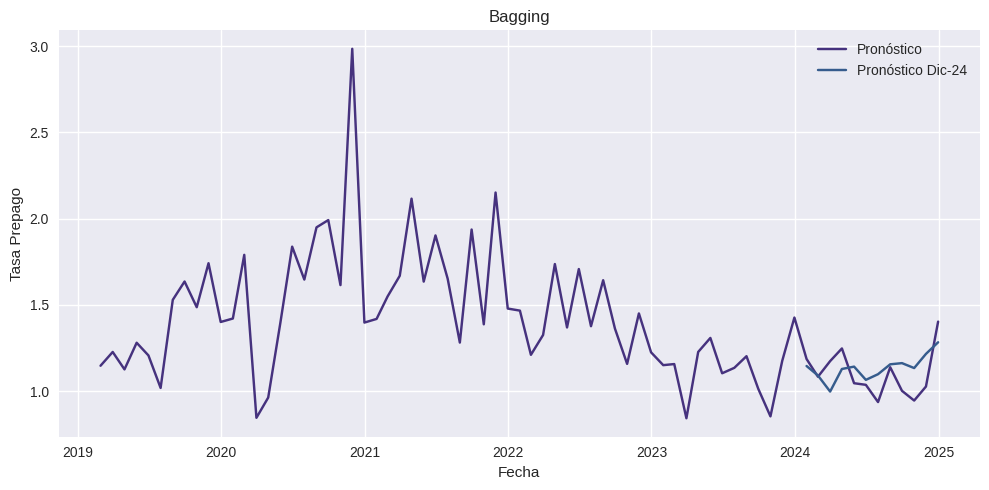

In [471]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Pronóstico")
plt.plot(y_pred.index, y_pred.values, label="Pronóstico Dic-24")
plt.title(f"Bagging")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

#4. Blending

In [472]:
base_xgb = XGBRegressor(
    n_estimators=1200, learning_rate=0.04, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=0, tree_method='hist'
)
base_rf = RandomForestRegressor(
    n_estimators=600, max_depth=None, min_samples_leaf=2, random_state=0
)

blender = Ridge(alpha=1.0, random_state=0)

preds, reals = [], []

for t in range(start_idx, len(df_all)):

    X_tr_full = X_all.iloc[:t]
    y_tr_full = y_all.iloc[:t]
    x_new = X_all.iloc[[t]]

    #para entrenar el blender hacemos split en el train
    X_tr = X_tr_full.iloc[:-12]
    y_tr = y_tr_full.iloc[:-12]
    X_val = X_tr_full.iloc[-12:]
    y_val = y_tr_full.iloc[-12:]


    m1 = base_xgb.__class__(**base_xgb.get_params())
    m2 = base_rf.__class__(**base_rf.get_params())
    m1.fit(X_tr, y_tr)
    m2.fit(X_tr, y_tr)

    # predicciones base para x_new
    p1_new = m1.predict(x_new)[0]
    p2_new = m2.predict(x_new)[0]

    P_val = np.column_stack([m1.predict(X_val), m2.predict(X_val)])
    blender.fit(P_val, y_val)
    y_hat = float(blender.predict([[p1_new, p2_new]])[0])

    preds.append(y_hat)
    reals.append(y_all.iloc[t])

y_pred = pd.Series(preds, index=idx_bt)
y_real = pd.Series(reals, index=idx_bt)

MAE_blender  = float((y_real - y_pred).abs().mean())
MAPE_blender = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print(f"MAE : {MAE_blender:.6f}")
print(f"MAPE: {MAPE_blender:.4f}%")

MAE : 0.111064
MAPE: 10.1681%


# Selección

In [473]:
rows = []

rows.append(MAE_xgboost)
rows.append(MAPE_xgboost)
rows.append(MAE_rf)
rows.append(MAPE_rf)
rows.append(MAE_sarimax)
rows.append(MAPE_sarimax)
rows.append(MAE_bagging)
rows.append(MAPE_bagging)
rows.append(MAE_boosting)
rows.append(MAPE_boosting)
rows.append(MAE_st)
rows.append(MAPE_st)
rows.append(MAE_blender)
rows.append(MAPE_blender)

modelos = [
    "XGBoost_MAE", "XGBoost_MAPE",
    "Random Forest_MAE", "Random Forest_MAPE",
    "SARIMAX_MAE", "SARIMAX_MAPE",
    "Bagging_MAE", "Bagging_MAPE",
    "Boosting_MAE", "Boosting_MAPE",
    "Stacking_MAE", "Stacking_MAPE",
    "Blending_MAE", "Blending_MAPE"
]

met = pd.DataFrame(rows)
met.columns = ["valor"]
met['index'] = modelos

met[['Modelo', 'Metrica']] = met['index'].str.split('_', n=1, expand=True)

tabla = met.pivot(index='Modelo', columns='Metrica', values='valor').reset_index()

tabla = tabla[['Modelo', 'MAE', 'MAPE']]

tabla.sort_values(by='MAE', ascending=True)

Metrica,Modelo,MAE,MAPE
2,Boosting,0.095750,8.579011
0,Bagging,0.096028,8.494343
6,XGBoost,0.105350,9.462573
3,Random Forest,0.107448,9.816473
5,Stacking,0.108787,10.204152
1,Blending,0.111064,10.168084
4,SARIMAX,0.264985,23.143776


Por los resultados de MAE se tomará el modelo de Boosting.

#Gráficos

In [474]:
preds, reals = [], []

gbr = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    random_state=0
)

for t in range(start_idx, len(df_all)):
    X_tr = X_all.iloc[:t]
    y_tr = y_all.iloc[:t]
    x_new = X_all.iloc[[t]]

    gbr.fit(X_tr, y_tr)
    preds.append(gbr.predict(x_new)[0])
    reals.append(y_all.iloc[t])

y_pred = pd.Series(preds, index=idx_bt)
y_real = pd.Series(reals, index=idx_bt)

MAE_boosting  = float((y_real - y_pred).abs().mean())
MAPE_boosting = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print(f"MAE : {MAE_boosting:.6f}")
print(f"MAPE: {MAPE_boosting:.4f}%")

MAE : 0.095750
MAPE: 8.5790%


Los residuos están distribuidos alrededor del cero, sin patrones marcados, por lo que se considera un buen modelo, sin sesgos relevantes.

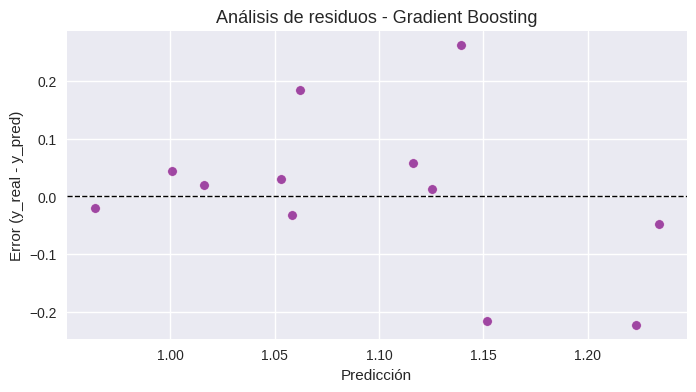

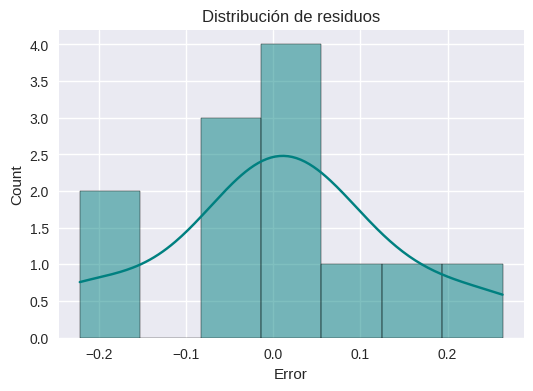

In [475]:
# Residuos
residuos = y_real - y_pred

plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred, y=residuos, color='purple', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.title('Análisis de residuos - Gradient Boosting', fontsize=13)
plt.xlabel('Predicción')
plt.ylabel('Error (y_real - y_pred)')
plt.show()

# Distribución de los residuos
plt.figure(figsize=(6,4))
sns.histplot(residuos, kde=True, color='teal')
plt.title('Distribución de residuos')
plt.xlabel('Error')
plt.show()

El siguiente gráfico muestra que las dos variables exógenas más relevantes son la TIIE y el lag 3 de TIIE.

Las siguientes dos variables importantes son lags de la serie misma, por lo que es importante el patrón estacional trimestral y anual.

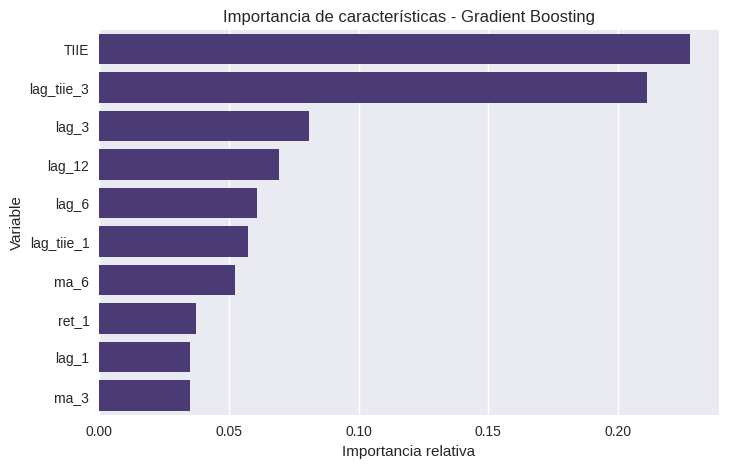

In [476]:
importances = gbr.feature_importances_
feat_names = X_all.columns

feat_imp = pd.DataFrame({'Feature': feat_names, 'Importancia': importances})
feat_imp = feat_imp.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Feature', data=feat_imp.head(10))
plt.title('Importancia de características - Gradient Boosting')
plt.xlabel('Importancia relativa')
plt.ylabel('Variable')
plt.show()